In [3]:
# STEP 1: Import Required Libraries
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import necessary modules from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc



In [4]:
# STEP 2: Configurations
# Set the file path and model directory
DATA_PATH = "healthcare_data.csv"   # Ensure the file is in the correct path
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Speed controls (adjust these as per your system or requirements)
USE_SAMPLE_FOR_EXPLORATION = False   # True => use a small sample for quick testing
SAMPLE_SIZE = 10000                  # if USE_SAMPLE_FOR_EXPLORATION is True, this is the sample size
N_ESTIMATORS = 60                    # number of trees for RandomForest
N_JOBS = -1                          # number of jobs for RandomForest, -1 uses all cores


In [5]:
# STEP 3: Load the Data
# Check if the file exists first
DATA_PATH = "healthcare_data.csv"  # Adjusted path to match your file name

if not os.path.isfile(DATA_PATH):
    raise FileNotFoundError(f"The file '{DATA_PATH}' was not found. Please check the file path.")

# Load the CSV file
try:
    df = pd.read_csv(DATA_PATH)
    print("Loaded rows:", len(df))
    print("Columns in dataset:", df.columns.tolist())
    display(df.head(3))  # Display first 3 rows for quick inspection

    # Quick preview of data
    print(df.info())
    print("\nMissing values per column:")
    print(df.isnull().sum())

except Exception as e:
    print(f"Error while loading the CSV: {e}")

Loaded rows: 55500
Columns in dataset: ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [6]:
# STEP 4: Fill Missing Values (Basic Cleaning)
# Handle trivial missing values for non-numeric columns (like categorical ones)
for col in ['Doctor', 'Hospital', 'Insurance Provider', 'Medication', 'Test Results']:
    if col in df.columns:
        df[col].fillna(df[col].mode().iloc[0], inplace=True)

# Convert 'Date of Admission' and 'Discharge Date' to datetime format
for date_col in ['Date of Admission', 'Discharge Date']:
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Create 'Length_of_Stay' based on 'Date of Admission' and 'Discharge Date'
if 'Date of Admission' in df.columns and 'Discharge Date' in df.columns:
    df['Length_of_Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
    # Replace negative or null 'Length_of_Stay' with the median value
    median_los = int(df['Length_of_Stay'].dropna().loc[lambda s: s >= 0].median() if not df['Length_of_Stay'].dropna().empty else 3)
    df['Length_of_Stay'] = df['Length_of_Stay'].apply(lambda x: median_los if (pd.isna(x) or x < 0) else x)
else:
    df['Length_of_Stay'] = 3  # Default value if the dates don't exist

# Ensure 'Billing Amount' is numeric and fill missing with the median
if 'Billing Amount' in df.columns:
    df['Billing Amount'] = pd.to_numeric(df['Billing Amount'], errors='coerce')
    df['Billing Amount'].fillna(df['Billing Amount'].median(), inplace=True)

# Clean up 'Age' column (convert to numeric and replace missing with median)
if 'Age' in df.columns:
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce').fillna(df['Age'].median()).astype(int)


/var/folders/1p/kgw_81px61jcrqrrnfwt7tq40000gn/T/ipykernel_788/3391147880.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode().iloc[0], inplace=True)
/var/folders/1p/kgw_81px61jcrqrrnfwt7tq40000gn/T/ipykernel_788/3391147880.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [7]:
# STEP 5: Create Target Variable 
# Check if 'Survived' exists or create a synthetic survival label
if 'Survived' not in df.columns:
    # Create synthetic survival outcome based on conditions (for demonstration purposes)
    def synthetic_survival(row):
        high_risk = {'Cancer', 'Cardiac', 'COPD', 'Injury'}
        tr = str(row.get('Test Results', 'Normal')).strip().lower()
        cond = row.get('Medical Condition', '').strip()
        age = row.get('Age', 50)
        adm = str(row.get('Admission Type', 'Routine')).strip().lower()
        
        if ('critical' in tr) or (cond in high_risk and age > 70) or (adm == 'emergency' and cond in high_risk):
            return 0  # Not survived
        if adm == 'urgent' and age > 80:
            return 0  # Not survived
        return 1  # Survived

    df['Survived'] = df.apply(synthetic_survival, axis=1)
    print("Created synthetic 'Survived' label (1=survived, 0=not).")
else:
    print("'Survived' column found - using provided labels.")

# Display survival counts
print("Survived counts:\n", df['Survived'].value_counts())


Created synthetic 'Survived' label (1=survived, 0=not).
Survived counts:
 Survived
1    49953
0     5547
Name: count, dtype: int64


In [8]:
# STEP 6: Select Features for Modeling
FEATURES = ['Age', 'Gender', 'Medical Condition', 'Admission Type', 'Medication', 'Test Results', 'Length_of_Stay']
FEATURES = [f for f in FEATURES if f in df.columns]
print("Using features:", FEATURES)

# Define the target variable for different tasks
X = df[FEATURES].copy()
y_reg = df['Billing Amount'] if 'Billing Amount' in df.columns else None
y_adm = df['Admission Type'] if 'Admission Type' in df.columns else None
y_surv = df['Survived']

# Optionally sample data for quick development
USE_SAMPLE_FOR_EXPLORATION = False
SAMPLE_SIZE = 10000
if USE_SAMPLE_FOR_EXPLORATION and len(X) > SAMPLE_SIZE:
    df_sample = pd.concat([X, df[['Billing Amount', 'Admission Type', 'Survived']]], axis=1).sample(SAMPLE_SIZE, random_state=42)
    X = df_sample[FEATURES]
    y_reg = df_sample['Billing Amount'] if 'Billing Amount' in df_sample.columns else None
    y_adm = df_sample['Admission Type'] if 'Admission Type' in df_sample.columns else None
    y_surv = df_sample['Survived']
    print(f"Using sample of size {len(X)} for development.")

Using features: ['Age', 'Gender', 'Medical Condition', 'Admission Type', 'Medication', 'Test Results', 'Length_of_Stay']


In [9]:
# STEP 7: Preprocessing Pipeline
# Categorical and numeric features
numeric_features = [c for c in FEATURES if df[c].dtype in [np.int64, np.float64]]
categorical_features = [c for c in FEATURES if c not in numeric_features]

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

# Numeric transformer pipeline: impute and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer pipeline: impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers into a single preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# Save preprocessor to disk (optional)
joblib.dump(preprocessor, 'models/preprocessor.joblib')
print("Preprocessor saved to:", 'models/preprocessor.joblib')


Numeric Features: ['Age', 'Length_of_Stay']
Categorical Features: ['Gender', 'Medical Condition', 'Admission Type', 'Medication', 'Test Results']
Preprocessor saved to: models/preprocessor.joblib


In [10]:
# STEP 8: Helper Function to Train and Save Models
def train_and_save_regressor(X, y, model_path, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('rf', RandomForestRegressor(n_estimators=60, n_jobs=-1, random_state=42))])
    
    print("Training regressor...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"Regressor RMSE: {rmse:.2f}, R2: {r2:.3f}")
    
    joblib.dump(model, model_path)
    print("Saved regressor to", model_path)
    return model, X_test, y_test, preds

# Call this function to train and save your regressor (if using 'Billing Amount' as target)
if y_reg is not None:
    model_path = os.path.join(MODEL_DIR, "regressor_model.joblib")
    model, X_test, y_test, preds = train_and_save_regressor(X, y_reg, model_path)

Training regressor...
Regressor RMSE: 14400.45, R2: -0.043
Saved regressor to models/regressor_model.joblib


In [11]:
# Helper function to train, evaluate, and save classifiers quickly
def train_and_save_classifier(X, y, model_path, test_size=0.2, stratify=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=stratify)
    
    # Define the classifier pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('rf', RandomForestClassifier(n_estimators=N_ESTIMATORS, n_jobs=N_JOBS, random_state=42))])
    
    print("Training classifier...")
    model.fit(X_train, y_train)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, preds)
    print(f"Classifier Accuracy: {acc:.3f}")
    print(classification_report(y_test, preds))
    
    # Save the trained model to disk
    joblib.dump(model, model_path)
    print("Saved classifier to", model_path)
    
    return model, X_test, y_test, preds


In [12]:
# %%
# STEP 9: Train Admission Type classifier (optional - you may want to predict patient type)
if y_adm is not None:
    adm_path = os.path.join(MODEL_DIR, 'admission_classifier.joblib')
    
    # Check if model already exists
    if os.path.exists(adm_path):
        print("Found existing saved admission classifier. Loading from disk.")
        adm_model = joblib.load(adm_path)
    else:
        # For Admission Type, stratify to keep class distribution
        adm_model, X_test_adm, y_test_adm, preds_adm = train_and_save_classifier(X, y_adm, adm_path, stratify=y_adm)
else:
    print("No Admission Type column - skipping admission classifier.")
    adm_model = None


Found existing saved admission classifier. Loading from disk.


In [13]:
# %%
# STEP 10: Train survival classifier (target created earlier)
surv_path = os.path.join(MODEL_DIR, 'survival_classifier.joblib')

# Check if survival model exists
if os.path.exists(surv_path):
    print("Found existing saved survival classifier. Loading from disk.")
    surv_model = joblib.load(surv_path)
else:
    # If not, train the model and save it
    surv_model, X_test_surv, y_test_surv, preds_surv = train_and_save_classifier(X, y_surv, surv_path, stratify=y_surv)


Found existing saved survival classifier. Loading from disk.


In [14]:
# %%
# STEP 11: Feature importance (from RandomForest) - for interpretability
# We extract importance from the underlying RF if available
def get_feature_importances(trained_pipe, top_n=20):
    try:
        rf = trained_pipe.named_steps['rf']
        # build feature names from preprocessor
        # numeric features + onehot names
        num_feats = numeric_features
        onehot = trained_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feat_names = list(onehot.get_feature_names_out(categorical_features)) if hasattr(onehot, 'get_feature_names_out') else []
        feat_names = list(num_feats) + cat_feat_names
        importances = rf.feature_importances_
        imp_series = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(top_n)
        return imp_series
    except Exception as e:
        print("Could not extract feature importances:", e)
        return None

# Ensure that reg_model is created before accessing it
if 'reg_model' in locals() and reg_model is not None:
    fi_reg = get_feature_importances(reg_model)
    if fi_reg is not None:
        print("Top features for billing regression:")
        print(fi_reg)
else:
    print("No regression model found. Skipping feature importance for regression.")

# Ensure that surv_model is created before accessing it
if 'surv_model' in locals() and surv_model is not None:
    fi_surv = get_feature_importances(surv_model)
    if fi_surv is not None:
        print("Top features for survival classifier:")
        print(fi_surv)
else:
    print("No survival model found. Skipping feature importance for survival.")


No regression model found. Skipping feature importance for regression.
Top features for survival classifier:
Medical Condition_Cancer          0.354034
Age                               0.298052
Admission Type_Emergency          0.113414
Admission Type_Urgent             0.091447
Admission Type_Elective           0.044845
Medical Condition_Arthritis       0.019267
Medical Condition_Asthma          0.018122
Medical Condition_Obesity         0.015258
Medical Condition_Diabetes        0.015101
Medical Condition_Hypertension    0.013809
Length_of_Stay                    0.010135
Test Results_Inconclusive         0.000743
Test Results_Abnormal             0.000727
Medication_Lipitor                0.000678
Medication_Paracetamol            0.000674
Gender_Male                       0.000674
Medication_Penicillin             0.000649
Gender_Female                     0.000634
Test Results_Normal               0.000624
Medication_Ibuprofen              0.000611
dtype: float64


In [15]:
# %%
# STEP 12: Save a sample processed dataframe for the Streamlit app (to show dashboards quickly)
small_preview = df.sample(min(1000, len(df)), random_state=42)
small_preview.to_csv(os.path.join(MODEL_DIR, 'sample_preview.csv'), index=False)
print("Saved sample preview to", os.path.join(MODEL_DIR, 'sample_preview.csv'))


Saved sample preview to models/sample_preview.csv


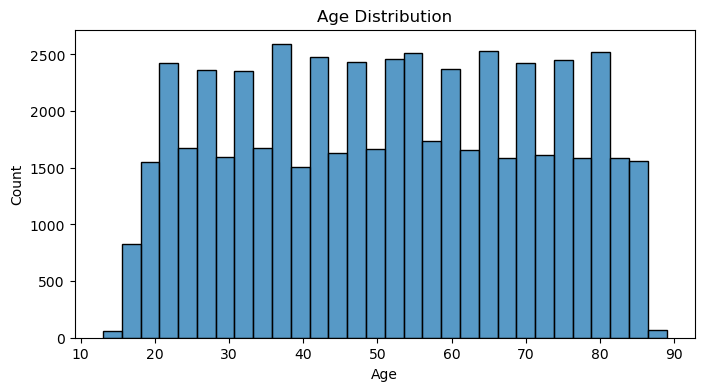

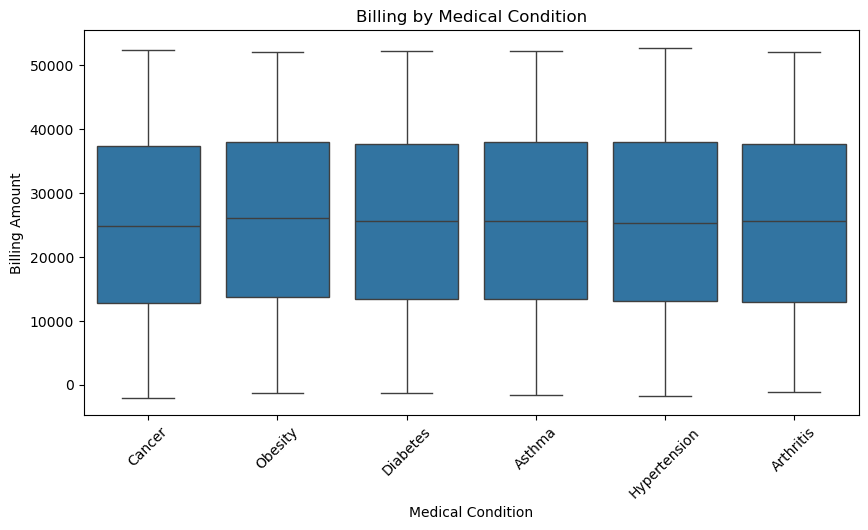

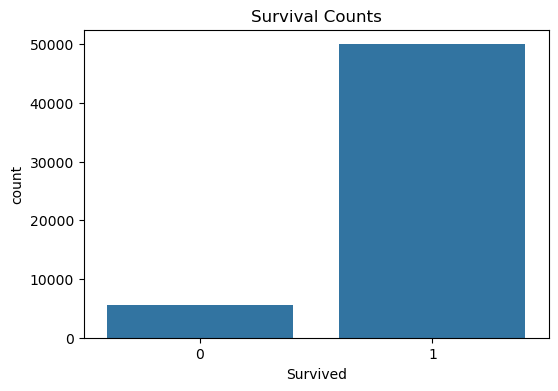

In [16]:
# %%
# STEP 13: Quick EDA (plots) - inline in notebook

# Age distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30)
plt.title("Age Distribution")
plt.show()

# Billing vs Condition boxplot if Billing exists
if 'Billing Amount' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Medical Condition', y='Billing Amount', data=df)
    plt.xticks(rotation=45)
    plt.title("Billing by Medical Condition")
    plt.show()

# Survival counts
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df)
plt.title("Survival Counts")
plt.show()


In [17]:
# %% # step 14:
# DONE - Models are saved to 'models' folder. Next: use app.py to run Streamlit UI that loads these models.
print("All done. Models (if trained) are in:", MODEL_DIR)


All done. Models (if trained) are in: models


In [23]:
# %%
# STEP 15: Classification Model Evaluation Metrics (Safe Version)

from sklearn.model_selection import train_test_split

# --- Admission Type Classifier Evaluation ---
if adm_model is not None:
    # Ensure test data exists
    if 'X_test_adm' not in locals() or 'y_test_adm' not in locals():
        X_train_adm, X_test_adm, y_train_adm, y_test_adm = train_test_split(
            X, y_adm, test_size=0.2, random_state=42, stratify=y_adm
        )

    preds_adm = adm_model.predict(X_test_adm)

    # Accuracy
    acc_adm = accuracy_score(y_test_adm, preds_adm)
    print(f"Admission Classifier Accuracy: {acc_adm:.3f}")

    # Confusion Matrix
    print("Admission Classifier Confusion Matrix:")
    cm_adm = confusion_matrix(y_test_adm, preds_adm)
    print(cm_adm)

    # Precision, Recall, F1-Score
    print("Admission Classifier Classification Report:")
    print(classification_report(y_test_adm, preds_adm))

Admission Classifier Accuracy: 1.000
Admission Classifier Confusion Matrix:
[[3731    0    0]
 [   0 3654    0]
 [   0    0 3715]]
Admission Classifier Classification Report:
              precision    recall  f1-score   support

    Elective       1.00      1.00      1.00      3731
   Emergency       1.00      1.00      1.00      3654
      Urgent       1.00      1.00      1.00      3715

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100



In [24]:
# --- Survival Classifier Evaluation ---
if surv_model is not None:
    # Ensure test data exists
    if 'X_test_surv' not in locals() or 'y_test_surv' not in locals():
        X_train_surv, X_test_surv, y_train_surv, y_test_surv = train_test_split(
            X, y_surv, test_size=0.2, random_state=42, stratify=y_surv
        )

    preds_surv = surv_model.predict(X_test_surv)

    # Accuracy
    acc_surv = accuracy_score(y_test_surv, preds_surv)
    print(f"Survival Classifier Accuracy: {acc_surv:.3f}")

    # Confusion Matrix
    print("Survival Classifier Confusion Matrix:")
    cm_surv = confusion_matrix(y_test_surv, preds_surv)
    print(cm_surv)

    # Precision, Recall, F1-Score
    print("Survival Classifier Classification Report:")
    print(classification_report(y_test_surv, preds_surv))

Survival Classifier Accuracy: 1.000
Survival Classifier Confusion Matrix:
[[1109    0]
 [   0 9991]]
Survival Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1109
           1       1.00      1.00      1.00      9991

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100

